# Schooling in Xenopus tadpoles: Power analysis

This is a supplementary notebook that generates some simulated data, and estimates the power analysis for a schooling protocol. The analysis subroutines are the same, or very close to ones from the actual notebook (**schooling_analysis**). The results of power analysis are given, and explained, in the text below, but can also be re-created by the reader, by re-running this notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.spatial
import scipy.stats as stats
from typing import List,Tuple

## 1. Generate simulated data

Data is generated in the following format:

    Layout of Tadpole dataframe:
           x       y     tx    ty
    0  7.391  14.783 -0.159 -0.14
    1  8.850  14.623 -0.180 -0.18
    2  7.751  12.426 -0.260 -0.24

where each line correponds to a "tadpole"; `x` and `y` columns give the position of the "tadpole's head" (virtual, in this case), and `tx` and `ty` are the positions of the "tail", relative to the "head". 

,x,y,tx,ty
0,13.731107,8.119075,0.093659,-0.388880
1,3.571264,7.455667,-0.145483,0.372605
2,12.036019,3.104354,0.033640,-0.398583
3,7.905670,10.335306,0.359552,0.175278
4,8.870942,9.888318,0.361276,0.171696
5,3.387572,5.368745,-0.347309,0.198436
6,3.958465,6.200295,-0.188182,0.352970
7,1.983955,8.964339,-0.205800,0.342996
8,10.050851,11.883881,0.351661,-0.190617
9,10.322811,9.868260,0.171136,-0.361542


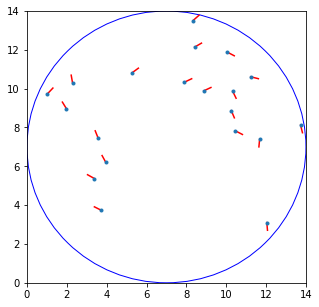

In [771]:
def simulate_data(ntads=10, schooling=0.5, alignment=0.6):
    """Simulates tadpole distribution in the dish.
    n = how many tadpoles to have
    
    schooling = the probability of being in a school (simplistic, binary approach)
    r = aligment radius
    alignment = alignment coefficient (1-noise_level)
    """
    
    R_DISH = 7
    TAD_LENGTH = 0.4
    N_ATTEMPTS = 20     # How many attempts to place each tadpole we would make
    JUMP = 1            # Jump, in cm, from one tadpole to another
    
    xy = np.zeros((ntads,2))
    tails = np.zeros((ntads,2))
    
    itad = 0
    while itad < ntads: # Simplified Bridson’s algorithm for Poisson-disc sampling
        if itad==0 or np.random.uniform()>schooling: # First point and non-schooled points placed at random
            drop = np.random.uniform(0, 2*R_DISH, 2)
        else:
            iparent = np.random.randint(itad)
            angle = np.random.uniform(0, 2*np.pi)
            d = np.random.uniform(JUMP, 2*JUMP)
            drop = xy[iparent,:] + np.array([np.cos(angle), np.sin(angle)])*d
        if np.sqrt((drop[0]-R_DISH)**2 + (drop[1]-R_DISH)**2) > R_DISH: # Outside of a dish, won't do
            continue
        good_point = True
        for iother in range(itad):
            if np.sqrt(np.sum(np.square(drop-xy[iother,:]))) < JUMP:    # Too close to another dot; won't do
                good_point = False
                break
        if not good_point:
            continue
        xy[itad,:] = drop
        
        # Make the tadpole perpendicular to the radius
        tails[itad,:] = [xy[itad,1]-R_DISH, -xy[itad,0]+R_DISH]
        tails[itad,:] = tails[itad,:]/np.linalg.norm(tails[itad,:])*TAD_LENGTH
        if itad>0:
            for iother in range(itad):
                d = np.linalg.norm(xy[itad,:]-xy[iother,:])
                tails[itad,:] += tails[iother,:]/(d**2)
        angle = np.random.uniform(0, 2*np.pi)
        randotail = np.array([np.cos(angle), np.sin(angle)])*TAD_LENGTH
        tails[itad,:] = tails[itad,:]/np.linalg.norm(tails[itad,:])*TAD_LENGTH
        tails[itad,:] = tails[itad,:]*alignment + randotail*(1-alignment)
        tails[itad,:] = tails[itad,:]/np.linalg.norm(tails[itad,:])*TAD_LENGTH
        # This code above with 3 normalizations in a row could have been prettier of course
            
        itad += 1
       
    return pd.DataFrame({'x':xy[:,0] , 'y':xy[:,1] , 'tx':tails[:,0] , 'ty':tails[:,1]})  

t = simulate_data(ntads=20)
plt.figure(figsize=(5,5))
for i in range(len(t)):
    plt.plot(t.x[i]+np.array([0, t.tx[i]]), t.y[i]+np.array([0, t.ty[i]]), 'r-')
plt.plot(t.x, t.y, '.')
plt.gca().add_artist(plt.Circle((7,7), 7, color='blue', fill=False, linestyle='-'))
plt.xlim([0, 14])
plt.ylim([0, 14])

t

## 2. Processing Tools

An exact copy of tools from the "main notebook" (as of 2020.08.01)), except that instead of extracing tadpoles from real data, we here simulate this data. (So `exctractTads` function is not actually used).

Layout of Tadpole dataframe:
          x         y        tx        ty
0  4.894911  4.487846 -0.399889 -0.009431
1  5.957087  1.180509 -0.342628 -0.206412
2  1.647202  7.464476 -0.196171  0.348593

Layout of Pairs dataframe:
    i   j      dist
0  18   0  5.113530
1   0  19  3.708869
2  19  18  3.985790


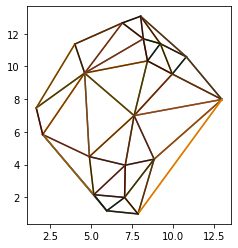

In [772]:
def getNFrames(data):
    """Returns the total number of frames."""
    return max(data.Frame)+1

def extractTads(data,frame):
    """Splits the data into XY position of each head, and _relative_ XY position of each tail."""
    xy = data.loc[data.Frame==frame,['X','Y']].to_numpy()
    heads = xy[0::2,:]
    tails = xy[1::2,:]-heads
    return pd.DataFrame({'x':heads[:,0] , 'y':heads[:,1] , 'tx':tails[:,0] , 'ty':tails[:,1]})  

def findNeighbors(tads): # Returns a new data frame, for edges
    """Triangulates the field, finds "neighbors". No thresholding of distance."""
    xy = tads[['x','y']]
    tri = scipy.spatial.Delaunay(xy,qhull_options="QJ").simplices # "QJ" is needed to retain
                                                                  # all tadpoles, including isolated ones
    listOfPairs = [] # Array of tuples to describe all pairs of points
    flip = lambda x: (x[1],x[0])  # A local function to flip tuples
    for i in range(tri.shape[0]): # Go through all edges of Delaunay triangles, include each one only once
        triangle = [tuple(tri[i,[0,1]]) , tuple(tri[i,[1,2]]) , tuple(tri[i,[2,0]])]
        for p in triangle:
            if p not in listOfPairs and flip(p) not in listOfPairs:
                listOfPairs += [p]
    out = pd.DataFrame({'i':[a for (a,b) in listOfPairs] , 'j':[b for (a,b) in listOfPairs]})
    return out

def findDistances(tads,pairs):
    """Calculates distances between pairs of neighboring tadpoles."""
    xy = tads[['x','y']].values
    dist = [np.linalg.norm(xy[p[0],]-xy[p[1],]) for p in pairs[['i','j']].values.tolist()]
    pairs['dist'] = dist
    return pairs

# --- Test, for the first frame
tads = simulate_data(ntads=20)
pairs = findNeighbors(tads)
pairs = findDistances(tads,pairs)

print('Layout of Tadpole dataframe:')
print(tads[:3])
print('\nLayout of Pairs dataframe:')
print(pairs[:3])

# Test figure with edge colors proportional to their distance
fig = plt.figure()
ax = fig.add_subplot(111)
xy = tads[['x','y']].values
for i in range(len(pairs)):
    p = pairs[['i','j']].values.tolist()[i]
    ax.plot([xy[p[0],0] , xy[p[1],0]],[xy[p[0],1] , xy[p[1],1]]) # Point
    ax.plot(*([xy[p[i],_] for i in range(2)] for _ in range(2)),
           color=np.array([1,0.5,0])*pairs['dist'].iloc[i]/pairs[['dist']].max().values*0.9) 
    # The awkward construction above draws lines between neighboring tadpoles
ax.set_aspect('equal')

## 3. Tools to Process Angles

Exactly same as in the main notebook (as of 2020.08.01)

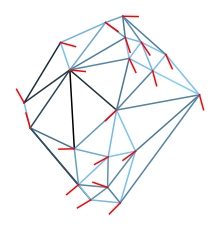

In [773]:
def findAngles(tads,pairs):
    '''Angles between pairs of tadpoles'''
    tails = tads[['tx','ty']].values # Go from pandas to lists, to utilize list comprehension
    norms = [np.linalg.norm(tails[i,]) for i in range(tails.shape[0])]
    angle = [np.arccos(np.dot(tails[p[0],],tails[p[1],])/(norms[p[0]]*norms[p[1]])) 
             for p in pairs[['i','j']].values.tolist()]
    pairs['angle'] = np.array(angle)/np.pi*180
    return pairs

def niceTadFigure(ax,tads,pairs):
    """Nice picture for troubleshooting."""
    xy = tads[['x','y']].values
    tails = tads[['tx','ty']].values
    ang = pairs[['angle']].values
    for i in range(len(pairs)):
        p = pairs[['i','j']].values.tolist()[i]
        ax.plot(*([xy[p[i],_] for i in range(2)] for _ in range(2)),
           color=np.array([0.5,0.8,1])*(1-ang[i]/max(ang))) # Tadpole-tapole Edges
    for i in range(xy.shape[0]):
        nm = np.linalg.norm(tails[i,])
        ax.plot(xy[i,0]+[0,tails[i,0]/nm], xy[i,1]+[0,tails[i,1]/nm] , '-',color='red')
    ax.set_aspect('equal')
    ax.axis('off')

# --- Test, for the first frame
pairs = findAngles(tads,pairs)
    
fig = plt.figure()
ax = fig.add_subplot(111)
niceTadFigure(ax,tads,pairs)
#plt.savefig('crystal_pic.svg', format='svg')

## 4. Define full processor and dataset visualization

This function is adjusted to look like the procesisng function from the main notebook, but actually call the simulation function.

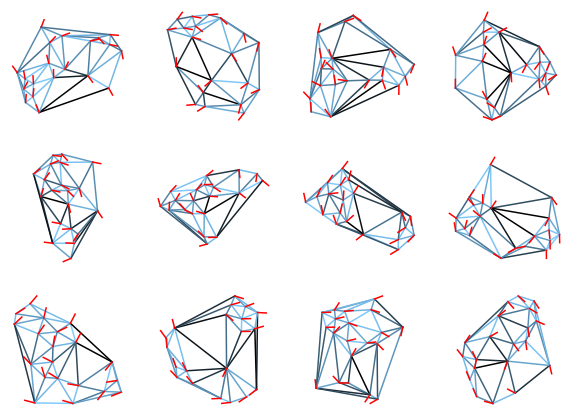

In [774]:
def processEverything(n=12, show_image=False):
    """Process one full dataset."""
    if show_image:
        fig = plt.figure(figsize=(10,10));

    fullDf = pd.DataFrame()
    for iframe in range(12):
        tads = simulate_data(ntads=20)
        pairs = findNeighbors(tads)
        pairs = findDistances(tads,pairs)
        angl = findAngles(tads,pairs)

        fullDf = fullDf.append(pd.DataFrame({'frame': [iframe]*len(pairs)}).join(pairs))

        if show_image:
            ax = fig.add_subplot(4,4,iframe+1)
            niceTadFigure(ax,tads,pairs)
    return fullDf
    
out = processEverything(show_image=True)

## 5. Sample analysis

In [765]:
# Prepare the data
out = processEverything(show_image=False)
out_treatment = processEverything(show_image=False)

Are the inter-tadpole distances different between real and reshuffled data?
(was their clumping?)
T-test: t =  0.585543400049321 ; p-value =  0.5582955066442163

Was the distribution of distances non-random, from frame to frame?
Kolmogorov-Smirnov test p-value =  0.864597243467909


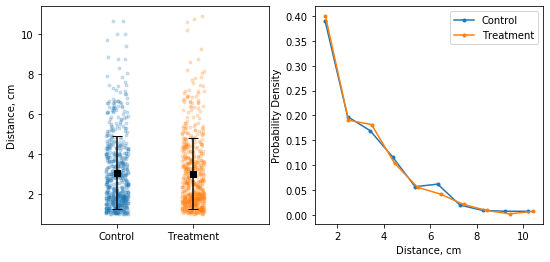

In [766]:
def two_groups_plot(y1, y2, labels):
    """A basic two-groups plot"""
    plt.plot(1+(np.random.uniform(size=y1.shape[0])-0.5)*0.3, y1, '.', alpha=0.2, zorder=-1)
    plt.plot(2+(np.random.uniform(size=y2.shape[0])-0.5)*0.3, y2, '.', alpha=0.2, zorder=-1)
    # Zorder is set to negative to hack around a bug in matplotlib that places errorbars below plots
    plt.errorbar(1, np.mean(y1), np.std(y1), color='k', marker='s', capsize=5)
    plt.errorbar(2, np.mean(y2), np.std(y2), color='k', marker='s', capsize=5)
    plt.xlim(0,3)
    plt.xticks(ticks=[1,2], labels=labels)

def compare_distances(out1,out2,labels):
    """Visualizes distances, reports a stat test"""
    N_BINS = 10
    
    d = out1['dist'].values
    d2 = out2['dist'].values

    plt.figure(figsize=(9,4))
    ax = plt.subplot(121)
    two_groups_plot(d, d2, labels)
    plt.ylabel('Distance, cm')
    
    ax = plt.subplot(122)
    #plt.hist(d , bins=30, density=True, alpha=0.5);
    #plt.hist(d2, bins=30, density=True, alpha=0.5);
    y1,x1 = np.histogram(d, bins=N_BINS, density=True)
    y2,x2 = np.histogram(d2, bins=N_BINS, density=True)
    centers = lambda x: np.mean(np.vstack((x[:-1],x[1:])), axis=0) # Centers of each bin
    plt.plot(centers(x1),y1,'.-')
    plt.plot(centers(x2),y2,'.-')
    plt.xlabel('Distance, cm')
    plt.ylabel('Probability Density')
    plt.legend(labels, loc='upper right')

    print('Are the inter-tadpole distances different between real and reshuffled data?')
    print('(was their clumping?)')
    test_results = stats.ttest_ind(d,d2)
    print('T-test: t = ', test_results.statistic, '; p-value = ',test_results.pvalue)

    print('\nWas the distribution of distances non-random, from frame to frame?')
    test_results = scipy.stats.ks_2samp(d,d2)
    print('Kolmogorov-Smirnov test p-value = ',test_results.pvalue)

compare_distances(out, out_treatment, ['Control','Treatment'])
#plt.savefig('distances.svg', format='svg')


Was the distribution of distances non-random, from frame to frame?
Kolmogorov-Smirnov test p-value =  0.1876045481128641


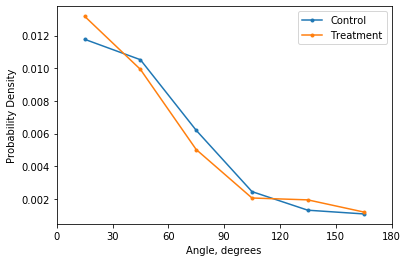

In [767]:
def compare_angles(out, out2, labels):
    """Visualizes angles, reports a stat test."""
    HIST_BIN = 30 # Histogram step, in degrees
    
    a = out['angle'].values
    a2 = out2['angle'].values

    #plt.hist(a , bins=np.arange(0,180+10,10), density=True, alpha=0.5);
    #plt.hist(a2, bins=np.arange(0,180+10,10), density=True, alpha=0.5);
    
    preset_bins = np.arange(0,180+HIST_BIN, HIST_BIN)    
    y1,x1 = np.histogram(a,  bins=preset_bins, density=True)
    y2,x2 = np.histogram(a2, bins=preset_bins, density=True)
    centers = lambda x: np.mean(np.vstack((x[:-1],x[1:])), axis=0) # Centers of each bin
    plt.plot(centers(x1),y1,'.-')
    plt.plot(centers(x2),y2,'.-')
    plt.xticks(np.arange(0,180+30,30))
    plt.xlabel('Angle, degrees')
    plt.ylabel('Probability Density')
    plt.legend(labels, loc='upper right')

    print('\nWas the distribution of distances non-random, from frame to frame?')
    test_results = scipy.stats.ks_2samp(a,a2)
    print('Kolmogorov-Smirnov test p-value = ',test_results.pvalue)
    
compare_angles(out, out_treatment, ['Control','Treatment'])
#plt.savefig('angles.svg', format='svg')

## 6. For the control dataset, reshuffle the data, compare real data to reshuffled

If the notebook is executed cell by cell, by now the results of the pairwise analysis (angles are distances) are stored in the dataframe "out". Below, we create a new dataframe "out_shuffled" that contains same analysis, but on the reshuffled data (with tadpoles randomly reshuffled between frames).

As each tadpole is represented by 2 points (head and tail), we cannot just reshuffle rows, but need to reshuffle pairs of rows.

In [768]:
# Time to reshuffle
def shuffleTads(data):
    '''Reshuffles tadpoles within between frames witn one global permutation.'''
    nd = data.copy()
    p = np.random.permutation(len(nd)//2)
    k = [a for sublist in [[2*j,2*j+1] for j in p] for a in sublist] # Pair-shuffling
    # Above: calculates reshuffled _consecutive pairs_, like [2 3  6 7  0 1  4 5] etc.
    # (Because in the original dataset points in go in pairs: head-tail, remember?)
    nd = nd.iloc[k]
    nd = nd.reset_index(drop=True)  # without drop=True it adds a new column called 'index'
    nd['Frame'] = data['Frame'] # After everything is reshuffled, reset frame numbers
    return nd

data_shuffled = shuffleTads(data)
out_shuffled = processEverything(data_shuffled)

NameError: name 'data' is not defined

Are the inter-tadpole distances different between real and reshuffled data?
(was their clumping?)
T-test: t =  -2.9289891481577732 ; p-value =  0.0034671476863756697

Was the distribution of distances non-random, from frame to frame?
Kolmogorov-Smirnov test p-value =  2.9303832822402676e-05


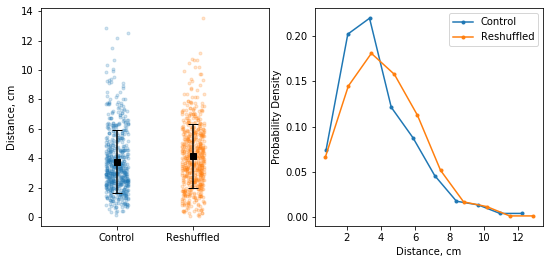

In [13]:
# Compare proper and randomized distances
compare_distances(out, out_shuffled, ['Control','Reshuffled'])


Was the distribution of distances non-random, from frame to frame?
Kolmogorov-Smirnov test p-value =  0.13870907506900199


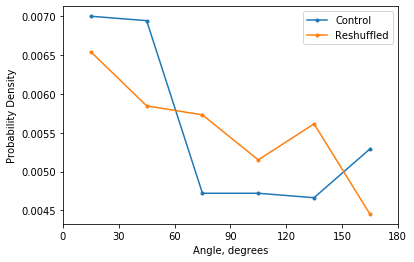

In [11]:
# Compare proper and randomized angles
compare_angles(out, out_shuffled, ['Control','Reshuffled'])